# Lesson 15 - use antibiotics wisely!

The UK Health Security Agency developed the UK Access, Watch, Reserve, and Other classification for antibiotics (UK-AWaRe). This classification holds four categories:

1. **Access antibiotics** are generally narrow-spectrum and associated with a lower risk of resistance. They are recommended as first or second choice options for common infections and should be readily available.
2. **Watch antibiotics** are broader-spectrum with a higher resistance potential. Their use should be limited to specific indications and monitored closely.
3. **Reserve antibiotics** are last-line treatments, often reserved for severe infections caused by multidrug-resistant organisms. These medicines require strict oversight to maintain their effectiveness.
4. **Other**

It is useful to see what fraction of all prescriptions are from the **watch** and **reserve** groups, as these should be used cautiously to reduce antibiotic resistence and hence effectiveness.

You can see the results of the Bennett analysis of the UK-AWaRe [here](https://openprescribing.net/measure/aware_antibiotics/).

Let's have a go at getting the data for the above ask ourselves and plotting it.

## Imports and Path objects

You should be happy with imports and Path objects now:

In [1]:
from pathlib import Path
from ebmdatalab import bq

DATA_FOLDER = Path("data")

And here we send off the SQL query and save the results in a csv file.

In [2]:
sql = """
-- Get the month, aware (access, watch and reserve) and sum of items
SELECT month, aware, SUM(items) AS items

-- Use the below database table
FROM measures.vw__aware_abx

-- Pick out only rows where aware is either Access, Watch or Reserve
WHERE aware IN ('Access','Watch','Reserve')

-- We group our results first by month and then a sub-group of aware value
GROUP BY month, aware

-- We finally order by month and then aware
ORDER BY month, aware
"""

raw = bq.cached_read(sql, DATA_FOLDER / "aware_raw.csv", use_cache=True)
                    
raw

,month,aware,items
0,2010-08-01 00:00:00+00:00,Access,1802654
1,2010-08-01 00:00:00+00:00,Reserve,2678
2,2010-08-01 00:00:00+00:00,Watch,656873
3,2010-09-01 00:00:00+00:00,Access,2086256
4,2010-09-01 00:00:00+00:00,Reserve,2828
...,...,...,...
535,2025-06-01 00:00:00+00:00,Reserve,2523
536,2025-06-01 00:00:00+00:00,Watch,430101
537,2025-07-01 00:00:00+00:00,Access,1796440
538,2025-07-01 00:00:00+00:00,Reserve,2412


## Let's clean up those dates

The date and time values `2010-08-01 00:00:00+00:00` look a little messy, let's get ride of the time value:

In [3]:
import pandas as pd

raw["month"] = pd.to_datetime(raw["month"], utc=True).dt.tz_convert(None).dt.date

raw

,month,aware,items
0,2010-08-01,Access,1802654
1,2010-08-01,Reserve,2678
2,2010-08-01,Watch,656873
3,2010-09-01,Access,2086256
4,2010-09-01,Reserve,2828
...,...,...,...
535,2025-06-01,Reserve,2523
536,2025-06-01,Watch,430101
537,2025-07-01,Access,1796440
538,2025-07-01,Reserve,2412


## Go wide!

This bit is magical, well almost. What we do here is 3-staged:
```python
raw.pivot(index="month", columns="aware", values="items")
```
In the above code, we take the `raw` data, cluster all of the `aware` values associated with the same date and put them in new columns

```python
.fillna(0)
```

This bit of code fills in data that is missing with a zero `0`.

```python
.reset_index()
```

This last bit of code puts the month in its own column (useful for calculations later).

Putting the data in this `wide format` helps us prepare the data to then plot it out.

In [4]:
wide_format = (
    raw.pivot(index="month", columns="aware", values="items")
    .fillna(0)
    .reset_index()
)

wide_format

aware,month,Access,Reserve,Watch
0,2010-08-01,1802654,2678,656873
1,2010-09-01,2086256,2828,740878
2,2010-10-01,2228913,2740,768349
3,2010-11-01,2350800,2856,793746
4,2010-12-01,3055078,3163,970321
...,...,...,...,...
175,2025-03-01,2054574,1688,482196
176,2025-04-01,1893152,1727,451063
177,2025-05-01,1809292,2371,445212
178,2025-06-01,1745593,2523,430101


## Hold the phone!

**Now just to make things** more interesting, and also to fit everything into the standard screen width, we have used parentheses `( )` to enable us to place the code over several lines instead of just one line. We will do this in a few places to keep you on your toes! But trust me, it is for your own good!

## Numerator

Let's calculate the numerators. As you can see this is done by adding the sum of `Watch` and `Reserve` items.

In [5]:
wide_format["numerator_items"] = wide_format["Watch"] + wide_format["Reserve"]

## Denominator

Let's calculate the denominators. As you can see this is the sum of all three aware types that we have at hand (ie `Access`, `Watch` and `Reserve`).

In [6]:
wide_format["denominator_items"] = (
    wide_format["Access"] 
    + wide_format["Watch"] 
    + wide_format["Reserve"]
)

## Fraction and the percentages

Here we are working out fractions:

```python
wide_format["numerator_items"]
    .div(wide_format["denominator_items"])
```

And then multiplying by 100 to get a percentage:

```python
.mul(100)
```

And then rounding up to 2 decimal points

In [7]:
wide_format["percent_watch_aware"] = (
    wide_format["numerator_items"]
    .div(wide_format["denominator_items"])
    .mul(100)
    .round(1)
)

wide_format

aware,month,Access,Reserve,Watch,numerator_items,denominator_items,percent_watch_aware
0,2010-08-01,1802654,2678,656873,659551,2462205,26.8
1,2010-09-01,2086256,2828,740878,743706,2829962,26.3
2,2010-10-01,2228913,2740,768349,771089,3000002,25.7
3,2010-11-01,2350800,2856,793746,796602,3147402,25.3
4,2010-12-01,3055078,3163,970321,973484,4028562,24.2
...,...,...,...,...,...,...,...
175,2025-03-01,2054574,1688,482196,483884,2538458,19.1
176,2025-04-01,1893152,1727,451063,452790,2345942,19.3
177,2025-05-01,1809292,2371,445212,447583,2256875,19.8
178,2025-06-01,1745593,2523,430101,432624,2178217,19.9


## Clean it up!

Let's remove all of the columns we no longer need as we have calculated what we need to next plot out the data. We do this by stating what columns we need in square brackets within square brackets.

In [8]:
final_data = wide_format[["month", "percent_watch_aware"]]

final_data

aware,month,percent_watch_aware
0,2010-08-01,26.8
1,2010-09-01,26.3
2,2010-10-01,25.7
3,2010-11-01,25.3
4,2010-12-01,24.2
...,...,...
175,2025-03-01,19.1
176,2025-04-01,19.3
177,2025-05-01,19.8
178,2025-06-01,19.9


## Show us the goods!

Next we ask the kind `matplotlib` library to make a plot of our data.

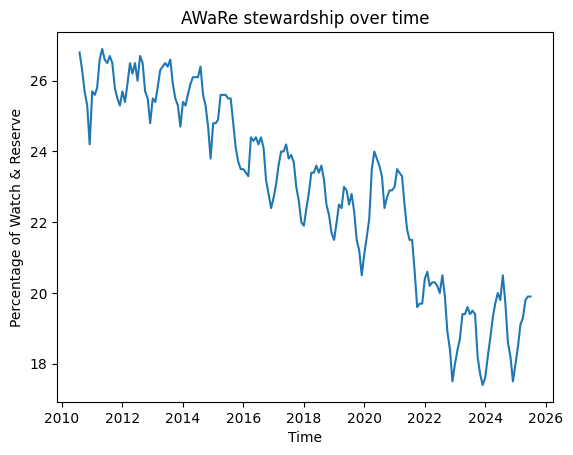

In [16]:
# Import the plot module and call it 'plt'
import matplotlib.pyplot as plt

# We create an `axes` object to put out data into
ax = final_data.plot(
    x="month",
    y="percent_watch_aware",
    kind="line",
    legend=False
)

# We set out x and y axis labels
ax.set_ylabel("Percentage of Watch & Reserve")
ax.set_xlabel("Time")

# We add a nice title
ax.set_title("AWaRe stewardship over time")

# Plot it!
plt.show()